# Purpose
This notebooks adapts the weights scrapped online to my implementation architecture.

# Import

In [1]:
import torch
import torchvision
from glic.networks.completion_network import CompletionNetwork
from collections import OrderedDict
import pandas as pd
import torch.nn as nn

# From https://github.com/satoshiiizuka/siggraph2017_inpainting

## Compare the architectures

In [2]:
# my implementation CN architecure
my_cn = CompletionNetwork()
my_cn_state_dict = my_cn.state_dict()
my_cn_shapes = OrderedDict([(k, v.shape) for k, v in my_cn_state_dict.items()])
my_cn_shapes_serie = pd.Series(my_cn_shapes.values(),index = my_cn_shapes.keys())

In [3]:
# # download the weight
# trained_cn_weights_address = "http://iizuka.cs.tsukuba.ac.jp/data/completionnet_places2.t7"
# import wget
# wget.download(trained_cn_weights_address,"../logs/scrapped_weights/trained_cn_weights.t7")

Weights were converted using https://github.com/clcarwin/convert_torch_to_pytorch  
*The github project had to be forked to account for SpacialDilatedConvolution*

In [4]:
# load the converted weights
scrapped_weights = torch.load("../logs/scrapped_weights/trained_cn_weights.pth")
scrapped_weights_shapes = OrderedDict([(k, v.shape) for k, v in scrapped_weights.items()])
scrapped_weights_shapes_serie = pd.Series(scrapped_weights_shapes.values(),index = scrapped_weights_shapes.keys())

In [5]:
my_cn_shapes_serie

cn_net.0.0.weight                  (64, 3, 5, 5)
cn_net.0.1.weight                          (64,)
cn_net.0.1.bias                            (64,)
cn_net.0.1.running_mean                    (64,)
cn_net.0.1.running_var                     (64,)
                                       ...      
cn_net.15.1.running_mean                   (32,)
cn_net.15.1.running_var                    (32,)
cn_net.15.1.num_batches_tracked               ()
cn_net.16.0.weight                 (3, 32, 3, 3)
cn_net.16.0.bias                            (3,)
Length: 98, dtype: object

In [6]:
scrapped_weights_shapes_serie

0.weight                  (64, 4, 5, 5)
0.bias                            (64,)
1.weight                          (64,)
1.bias                            (64,)
1.running_mean                    (64,)
                              ...      
46.running_mean                   (32,)
46.running_var                    (32,)
46.num_batches_tracked               ()
48.weight                 (3, 32, 3, 3)
48.bias                            (3,)
Length: 114, dtype: object

## Layer by layer

### First layer

In [7]:
my_cn_shapes_serie.iloc[:6]

cn_net.0.0.weight                 (64, 3, 5, 5)
cn_net.0.1.weight                         (64,)
cn_net.0.1.bias                           (64,)
cn_net.0.1.running_mean                   (64,)
cn_net.0.1.running_var                    (64,)
cn_net.0.1.num_batches_tracked               ()
dtype: object

In [8]:
scrapped_weights_shapes_serie.iloc[:7]

0.weight                 (64, 4, 5, 5)
0.bias                           (64,)
1.weight                         (64,)
1.bias                           (64,)
1.running_mean                   (64,)
1.running_var                    (64,)
1.num_batches_tracked               ()
dtype: object

In [9]:
# get the alpha bias
conv2d = nn.Conv2d(4,64,kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
conv2d.parameters = scrapped_weights['0.weight']
rgb_channels = torch.zeros((3,256,256))
alpha_channel = torch.ones((1,256,256))
alpha_image = torch.concatenate((rgb_channels,alpha_channel))
alpha_bias = torch.mean(conv2d(alpha_image),dim=(1,2))

In [10]:
# set first layer
my_cn_state_dict['cn_net.0.0.weight'] = scrapped_weights['0.weight'][:,:3,:,:]
my_cn_state_dict['cn_net.0.1.weight'] = scrapped_weights['1.weight']
my_cn_state_dict['cn_net.0.1.bias'] = scrapped_weights['0.bias']+scrapped_weights['1.bias']+alpha_bias

In [11]:
# batch norm layer
shift = 1
for idx in range(3,6):
    my_cn_state_dict[my_cn_shapes_serie.index[idx]] = scrapped_weights[scrapped_weights_shapes_serie.index[idx+shift]]

### Other layers

In [12]:
def convert_layer(my_cn_layers_names,my_cn_state_dict,scrapped_weights_layers_names,scrapped_weights):
    """This function transfer the weights from scrapped weights to my implementation of CN.
    
    Args:
        my_cn_layers_names (list): list of layers names to be transfered in my implementation of CN.
        my_cn_state_dict (OrderedDict): my implementation of CN.
        scrapped_weights_layers_names (list): list of layers names to be transfered in scrapped weights.
        scrapped_weights (OrderedDict): scrapped weights.
    """

    generic_map = {0:[0],
                   1:[2],
                   2:[1,3],
                   3:[4],
                   4:[5],
                   5:[6],}
    assert len(my_cn_layers_names) == 6
    assert len(scrapped_weights_layers_names) == 7

    for idx in range(6):
        layer = my_cn_layers_names[idx]
        my_cn_state_dict[layer] = torch.zeros(my_cn_state_dict[layer].shape)
        for other_idx in generic_map[idx]:
            other_layer = scrapped_weights_layers_names[other_idx]
            my_cn_state_dict[layer] += scrapped_weights[other_layer]
            print(f"{other_layer} -> {layer}")

In [13]:
# other layers
for idx in range(1,len(my_cn_shapes_serie)//6):
    convert_layer(my_cn_shapes_serie.index[idx*6:idx*6+6],my_cn_state_dict,
                  scrapped_weights_shapes_serie.index[idx*7:idx*7+7],scrapped_weights)
    print("\n")

3.weight -> cn_net.1.0.weight
4.weight -> cn_net.1.1.weight
3.bias -> cn_net.1.1.bias
4.bias -> cn_net.1.1.bias
4.running_mean -> cn_net.1.1.running_mean
4.running_var -> cn_net.1.1.running_var
4.num_batches_tracked -> cn_net.1.1.num_batches_tracked


6.weight -> cn_net.2.0.weight
7.weight -> cn_net.2.1.weight
6.bias -> cn_net.2.1.bias
7.bias -> cn_net.2.1.bias
7.running_mean -> cn_net.2.1.running_mean
7.running_var -> cn_net.2.1.running_var
7.num_batches_tracked -> cn_net.2.1.num_batches_tracked


9.weight -> cn_net.3.0.weight
10.weight -> cn_net.3.1.weight
9.bias -> cn_net.3.1.bias
10.bias -> cn_net.3.1.bias
10.running_mean -> cn_net.3.1.running_mean
10.running_var -> cn_net.3.1.running_var
10.num_batches_tracked -> cn_net.3.1.num_batches_tracked


12.weight -> cn_net.4.0.weight
13.weight -> cn_net.4.1.weight
12.bias -> cn_net.4.1.bias
13.bias -> cn_net.4.1.bias
13.running_mean -> cn_net.4.1.running_mean
13.running_var -> cn_net.4.1.running_var
13.num_batches_tracked -> cn_net.4.1.nu

### Last layer

In [14]:
# last layer
my_cn_state_dict['cn_net.16.0.weight'] = scrapped_weights['48.weight']
my_cn_state_dict['cn_net.16.0.bias'] = scrapped_weights['48.bias']

## Test

In [15]:
# test
new_cn = CompletionNetwork()
new_cn.load_state_dict(my_cn_state_dict)

<All keys matched successfully>

In [16]:
# load the dataset
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)

# first batch
batch = next(iter(train_dataloader))[0]

# apply mask
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
from glic.utils import *
lm,em = generate_mask(4)
replacement_val = torch.rand(3)
masked_batch = apply_mask(batch,em,replacement_val)

# complete
new_cn.eval()
completed_batch = new_cn(masked_batch).detach()

Text(0.5, 1.0, 'Completed')

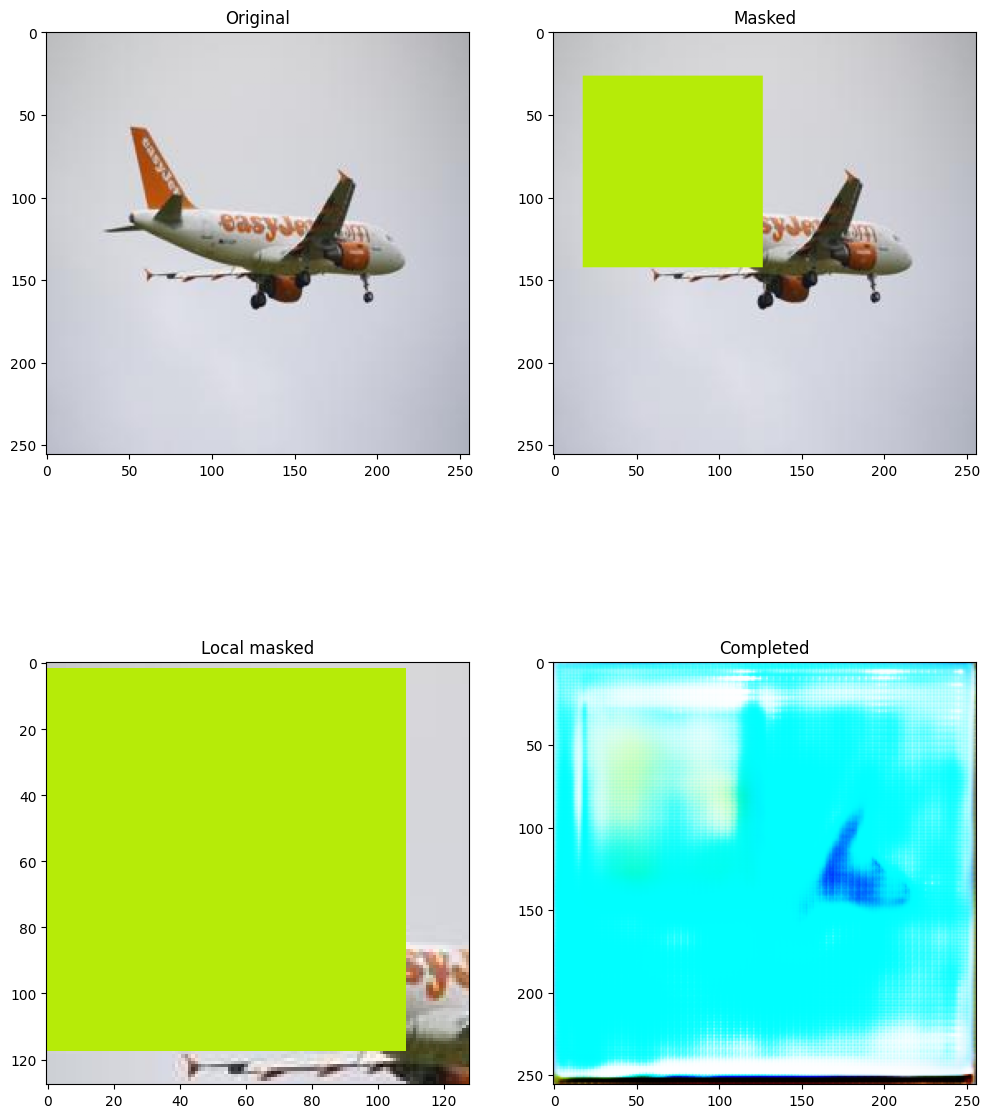

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(12,15))

# display the original image
axes[0][0].imshow(batch[0].permute(1,2,0))
axes[0][0].set_title('Original')

# display the masked image
axes[0][1].imshow(masked_batch[0].permute(1,2,0))
axes[0][1].set_title('Masked')

# display the local masked image
h,h2,w,w2 = lm[0]
axes[1][0].imshow(masked_batch[0][:,h:h2,w:w2].permute(1,2,0))
axes[1][0].set_title('Local masked')

# display the completed image
axes[1][1].imshow(completed_batch[0].permute(1,2,0))
axes[1][1].set_title('Completed')

# From https://github.com/otenim/GLCIC-PyTorch

To be explored:
- Use bias
- What about the alpha channel ?

In [18]:
# load weights
obtenim_state_dict = torch.load("../logs/scrapped_weights/model_cn")
obtenim_shapes = OrderedDict([(k, v.shape) for k, v in obtenim_state_dict.items()])
obtenim_shapes_serie = pd.Series(obtenim_shapes.values(),index = obtenim_shapes.keys())

In [19]:
# get the alpha bias
conv2d = nn.Conv2d(4,64,kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
conv2d.parameters = obtenim_state_dict['conv1.weight']
rgb_channels = torch.zeros((3,256,256))
alpha_channel = torch.ones((1,256,256))
alpha_image = torch.concatenate((rgb_channels,alpha_channel))
alpha_bias = torch.mean(conv2d(alpha_image),dim=(1,2))

In [20]:
# set first layer
my_cn_state_dict['cn_net.0.0.weight'] = obtenim_state_dict['conv1.weight'][:,:3,:,:]
my_cn_state_dict['cn_net.0.1.weight'] = obtenim_state_dict['bn1.weight']
my_cn_state_dict['cn_net.0.1.bias'] = obtenim_state_dict['conv1.bias']+obtenim_state_dict['bn1.bias']+alpha_bias

# batch norm layer
shift = 1
for idx in range(3,6):
    my_cn_state_dict[my_cn_shapes_serie.index[idx]] = obtenim_state_dict[obtenim_shapes_serie.index[idx+shift]]

In [21]:
# other layers
for idx in range(1,len(my_cn_shapes_serie)//6):
    convert_layer(my_cn_shapes_serie.index[idx*6:idx*6+6],my_cn_state_dict,
                  obtenim_shapes_serie.index[idx*7:idx*7+7],obtenim_state_dict)
    print("\n")

conv2.weight -> cn_net.1.0.weight
bn2.weight -> cn_net.1.1.weight
conv2.bias -> cn_net.1.1.bias
bn2.bias -> cn_net.1.1.bias
bn2.running_mean -> cn_net.1.1.running_mean
bn2.running_var -> cn_net.1.1.running_var
bn2.num_batches_tracked -> cn_net.1.1.num_batches_tracked


conv3.weight -> cn_net.2.0.weight
bn3.weight -> cn_net.2.1.weight
conv3.bias -> cn_net.2.1.bias
bn3.bias -> cn_net.2.1.bias
bn3.running_mean -> cn_net.2.1.running_mean
bn3.running_var -> cn_net.2.1.running_var
bn3.num_batches_tracked -> cn_net.2.1.num_batches_tracked


conv4.weight -> cn_net.3.0.weight
bn4.weight -> cn_net.3.1.weight
conv4.bias -> cn_net.3.1.bias
bn4.bias -> cn_net.3.1.bias
bn4.running_mean -> cn_net.3.1.running_mean
bn4.running_var -> cn_net.3.1.running_var
bn4.num_batches_tracked -> cn_net.3.1.num_batches_tracked


conv5.weight -> cn_net.4.0.weight
bn5.weight -> cn_net.4.1.weight
conv5.bias -> cn_net.4.1.bias
bn5.bias -> cn_net.4.1.bias
bn5.running_mean -> cn_net.4.1.running_mean
bn5.running_var -> cn_

In [22]:
# last layer
my_cn_state_dict['cn_net.16.0.weight'] = obtenim_state_dict['conv17.weight']
my_cn_state_dict['cn_net.16.0.bias'] = obtenim_state_dict['conv17.bias']

## Test

In [23]:
# test
new_cn = CompletionNetwork()
new_cn.load_state_dict(my_cn_state_dict)

<All keys matched successfully>

In [24]:
# next batch
batch = next(iter(train_dataloader))[0]

# apply mask
replacement_val = torch.tensor([0.5062325495504219, 0.4255871700324652, 0.38299278586700136])
from glic.utils import *
lm,em = generate_mask(4)
replacement_val = torch.rand(3)
masked_batch = apply_mask(batch,em,replacement_val)

# complete
new_cn.eval()
completed_batch = new_cn(masked_batch).detach()

Text(0.5, 1.0, 'Completed')

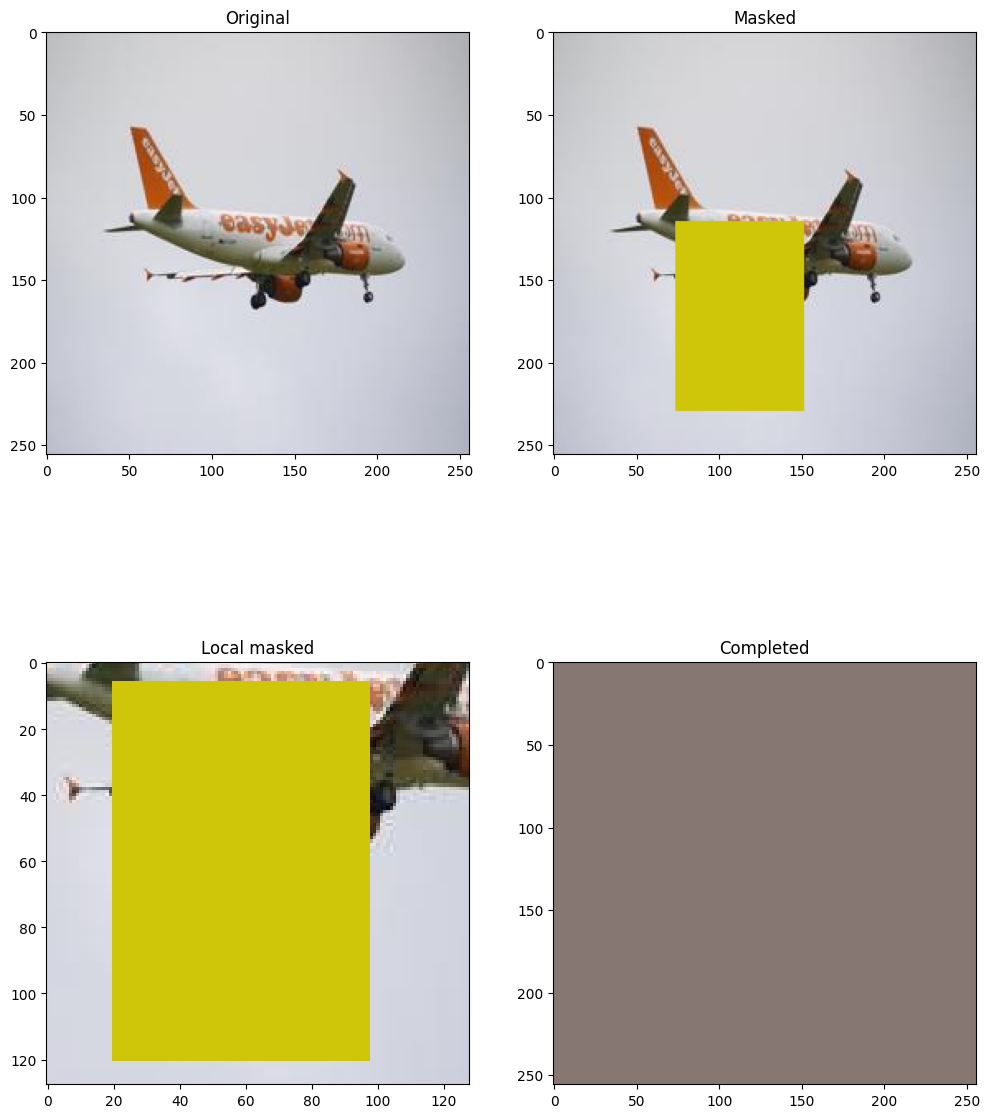

In [25]:
fig, axes = plt.subplots(2,2, figsize=(12,15))

# display the original image
axes[0][0].imshow(batch[0].permute(1,2,0))
axes[0][0].set_title('Original')

# display the masked image
axes[0][1].imshow(masked_batch[0].permute(1,2,0))
axes[0][1].set_title('Masked')

# display the local masked image
h,h2,w,w2 = lm[0]
axes[1][0].imshow(masked_batch[0][:,h:h2,w:w2].permute(1,2,0))
axes[1][0].set_title('Local masked')

# display the completed image
axes[1][1].imshow(completed_batch[0].permute(1,2,0))
axes[1][1].set_title('Completed')